In [1]:
import torch
from tqdm.auto import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
from datasets import load_dataset
from torchvision import transforms
from typing import Optional, Tuple, List
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import json
import torchvision.transforms.functional as F

c:\Users\Ivan\miniconda3\envs\course_project_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Vocab:
    def __init__(self, vocab_path=None, token_list=None):
        self.pad = "<PAD>"
        self.bos = "<SOS>"
        self.eos = "<EOS>"
        self.unk = "<UNK>"
        
        if vocab_path:
            self._load_from_file(vocab_path)
        elif token_list:
            self._build_from_tokens(token_list)
        else:
            raise ValueError("Either vocab_path or token_list must be provided")
        
        self.length = len(self.tokens)
    
    def _load_from_file(self, vocab_path):
        with open(vocab_path, 'r', encoding='utf-8') as f:
            loaded_vocab = json.load(f)
        
        if self.pad in loaded_vocab and self.bos in loaded_vocab and \
           self.eos in loaded_vocab and self.unk in loaded_vocab:
            self.stoi = loaded_vocab
            self.itos = {i: t for t, i in self.stoi.items()}
            self.tokens = [self.itos[i] for i in range(len(self.itos))]
        else:
            token_list = list(loaded_vocab.keys())
            self._build_from_tokens(token_list)
    
    def _build_from_tokens(self, token_list):
        special_tokens = [self.pad, self.bos, self.eos, self.unk]
        filtered_tokens = [t for t in token_list if t not in special_tokens]
        
        self.tokens = special_tokens + sorted(set(filtered_tokens))
        self.stoi = {t: i for i, t in enumerate(self.tokens)}
        self.itos = {i: t for t, i in self.stoi.items()}
    
    def __len__(self):
        return self.length
    
    def encode(self, token_seq):
        if not isinstance(token_seq, list):
            raise ValueError(f"Expected list of tokens, got {type(token_seq)}")
        
        if not all(isinstance(t, str) for t in token_seq):
            raise ValueError("All tokens must be strings")
        
        return [self.stoi[self.bos]] + \
               [self.stoi.get(t, self.stoi[self.unk]) for t in token_seq] + \
               [self.stoi[self.eos]]
    
    def decode(self, ids):
        eos_id = self.stoi[self.eos]
        pad_id = self.stoi[self.pad]
        bos_id = self.stoi[self.bos]
        
        toks = []
        for i in ids:
            if i == eos_id:
                break
            if i not in (pad_id, bos_id):
                toks.append(self.itos[i])
        
        return "".join(toks)
    
    def save(self, vocab_path):
        with open(vocab_path, 'w', encoding='utf-8') as f:
            json.dump(self.stoi, f, ensure_ascii=False, indent=2)


In [3]:
class ResizeWithPad:
    def __init__(self, target_size=224, fill=255):
        self.target_size = target_size
        self.fill = fill
    
    def __call__(self, image):
        w, h = image.size
        
        ratio = self.target_size / max(w, h)
        new_w = int(w * ratio)
        new_h = int(h * ratio)
        
        image = F.resize(image, (new_h, new_w), antialias=True)
        
        delta_w = self.target_size - new_w
        delta_h = self.target_size - new_h
        
        padding = (
            delta_w // 2,
            delta_h // 2,
            delta_w - (delta_w // 2),
            delta_h - (delta_h // 2)
        )
        
        image = F.pad(image, padding, fill=self.fill, padding_mode='constant')
        
        return image

In [4]:
from build_vocabulary import LaTeXTokenizer


class LaTeXDataset(Dataset):
    def __init__(
        self,
        images_dir: str,
        vocab,
        cache_dir: str = r'D:\datasets',
        split: str = 'train',
        transform: Optional[transforms.Compose] = None,
        max_latex_len: int = 512
    ):
        self.images_dir = Path(images_dir)
        self.vocab = vocab
        self.tokenizer = LaTeXTokenizer()
        self.transform = transform or self._default_transform()
        
        print(f"Loading dataset from HuggingFace...")
        ds = load_dataset(
            "hoang-quoc-trung/fusion-image-to-latex-datasets",
            cache_dir=cache_dir,
            split=split
        )
        
        print(f"Filtering by LaTeX length <= {max_latex_len}...")
        ds = ds.filter(lambda x: len(x['latex']) <= max_latex_len)
        
        self.filenames = ds['image_filename']
        self.latex_formulas = ds['latex']
        
        print(f"Dataset ready: {len(self.filenames)} samples")

    def _default_transform(self):
        return transforms.Compose([
            ResizeWithPad(target_size=224, fill=255),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        image_filename = self.filenames[idx]
        latex = self.latex_formulas[idx]
        img_path = self.images_dir / image_filename
        
        try:
            image = Image.open(img_path).convert('RGB')
            image = self.transform(image)
        except Exception as e:
            image = torch.zeros((3, 224, 224))
        
        tokens = self.tokenizer.tokenize(latex)
        encoded_tokens = self.vocab.encode(tokens)
        token_tensor = torch.LongTensor(encoded_tokens)
        
        return image, token_tensor

In [5]:
def collate_fn(batch):
    images, token_tensors = zip(*batch)
    
    images = torch.stack(images, dim=0)
    
    max_len = max(len(t) for t in token_tensors)
    pad_id = 0
    
    padded_tokens = []
    for tokens in token_tensors:
        padding = torch.full((max_len - len(tokens),), pad_id, dtype=torch.long)
        padded = torch.cat([tokens, padding])
        padded_tokens.append(padded)
    
    token_batch = torch.stack(padded_tokens, dim=0)
    
    return images, token_batch

In [6]:
def get_dataloaders(
    images_dir: str = r"D:\datasets\extraction\root\images",
    vocab=None,
    cache_dir: str = r'D:\datasets',
    batch_size: int = 32,
    num_workers: int = 0,
    max_latex_len: int = 512
):
    
    train_dataset = LaTeXDataset(
        images_dir=images_dir,
        vocab=vocab,
        cache_dir=cache_dir,
        split='train[:5%]',
        max_latex_len=max_latex_len
    )
    
    val_dataset = LaTeXDataset(
        images_dir=images_dir,
        vocab=vocab,
        cache_dir=cache_dir,
        split='validation',
        max_latex_len=max_latex_len
    )
    
    test_dataset = LaTeXDataset(
        images_dir=images_dir,
        vocab=vocab,
        cache_dir=cache_dir,
        split='test',
        max_latex_len=max_latex_len
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader

vocab = Vocab(vocab_path='tokens.json')

train_loader, val_loader, test_loader = get_dataloaders(
    images_dir=r"D:\datasets\extraction\root\images",
    vocab=vocab,
    cache_dir=r'D:\datasets',
    batch_size=128,
    num_workers=0,
    max_latex_len=80
)
    
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
    
images, tokens = next(iter(train_loader))
print(f"\nTrain batch - Images: {images.shape}, Tokens: {tokens.shape}")
    
images, tokens = next(iter(val_loader))
print(f"Val batch - Images: {images.shape}, Tokens: {tokens.shape}")
    
images, tokens = next(iter(test_loader))
print(f"Test batch - Images: {images.shape}, Tokens: {tokens.shape}")


Loading dataset from HuggingFace...
Filtering by LaTeX length <= 80...
Dataset ready: 87176 samples
Loading dataset from HuggingFace...
Filtering by LaTeX length <= 80...
Dataset ready: 1406 samples
Loading dataset from HuggingFace...
Filtering by LaTeX length <= 80...
Dataset ready: 5951 samples
Train batches: 682
Validation batches: 11
Test batches: 47

Train batch - Images: torch.Size([128, 3, 224, 224]), Tokens: torch.Size([128, 73])
Val batch - Images: torch.Size([128, 3, 224, 224]), Tokens: torch.Size([128, 71])
Test batch - Images: torch.Size([128, 3, 224, 224]), Tokens: torch.Size([128, 71])


In [7]:
import torchvision.models as models

class ResNetEncoder(nn.Module):
    def __init__(self, hidden_dim=256, freeze_layers=True):
        super().__init__()
        
        resnet = models.resnet50(pretrained=True)
        
        if freeze_layers:
            for param in resnet.layer1.parameters():
                param.requires_grad = False
            for param in resnet.layer2.parameters():
                param.requires_grad = False
            for param in resnet.layer3.parameters():
                param.requires_grad = False
            for param in resnet.layer4.parameters():
                param.requires_grad = True
        
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        self.projection = nn.Linear(2048, hidden_dim)
    
    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1).reshape(B, H*W, C)
        x = self.projection(x)
        return x


In [8]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_dim=256, num_layers=4, nhead=8, dropout=0.2, max_len=512):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, hidden_dim)
        self.pos_emb = nn.Embedding(max_len, hidden_dim)
        self.max_len = max_len

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=hidden_dim,
            nhead=nhead,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        
        # Создаем маску один раз и кэшируем
        self.register_buffer('causal_mask', torch.triu(torch.ones(max_len, max_len), diagonal=1).bool())

    def forward(self, tgt, memory):
        B, T = tgt.shape
        tok_emb = self.token_emb(tgt)  # [B,T,H]
        pos = self.pos_emb(torch.arange(T, device=tgt.device))  # [T,H]
        pos = pos.unsqueeze(0).expand(B, -1, -1)
        tgt_emb = tok_emb + pos

        # Используем маску
        tgt_mask = self.causal_mask[:T, :T]

        out = self.transformer_decoder(tgt_emb, memory, tgt_mask=tgt_mask)  # [B,T,H]
        return self.fc_out(out)

In [29]:
# Итоговая модель 
class FormulaRecognizer(nn.Module):
    def __init__(self, vocab_size, hidden_dim=256, max_len=512):
        super().__init__()
        self.encoder = ResNetEncoder(hidden_dim, freeze_layers=True)
        self.decoder = TransformerDecoder(vocab_size, hidden_dim, max_len=max_len)
        self.max_len = max_len
        self.vocab_size = vocab_size

    def forward(self, images, tokens):
        memory = self.encoder(images)  # [B,S,H]
        out = self.decoder(tokens[:, :-1], memory)  # предсказываем без последнего токена
        return out  # [B,T-1,V]

    def greedy_decode(self, image, vocab, device="cpu"):
        self.eval()
        with torch.no_grad():
            memory = self.encoder(image.unsqueeze(0).to(device))  # [1,S,H]

            # Используем правильные токены из словаря
            start_token = vocab.stoi[vocab.bos]
            end_token = vocab.stoi[vocab.eos]
            
            tokens = torch.tensor([[start_token]], device=device)
            for _ in range(self.max_len):
                out = self.decoder(tokens, memory)  # [1,T,V]
                next_token = out[:, -1, :].argmax(-1)  # [1]
                tokens = torch.cat([tokens, next_token.unsqueeze(0)], dim=1)
                if next_token.item() == end_token:
                    break

        return tokens.squeeze(0).tolist()
    
    
    def beam_search(self, image, vocab, device="cpu", beam_width=5, length_penalty=0.6):
        self.eval()
        with torch.no_grad():
            memory = self.encoder(image.unsqueeze(0).to(device))
            start_token = vocab.stoi[vocab.bos]
            end_token = vocab.stoi[vocab.eos]
            
            beams = [([start_token], 0.0)]
            completed = []
            
            for step in range(self.max_len):
                candidates = []
                
                for tokens, score in beams:
                    if tokens[-1] == end_token:
                        completed.append((tokens, score))
                        continue
                    
                    tokens_tensor = torch.tensor([tokens], device=device)
                    out = self.decoder(tokens_tensor, memory)
                    logits = out[:, -1, :]
                    log_probs = torch.log_softmax(logits, dim=-1)
                    
                    top_log_probs, top_indices = log_probs.topk(beam_width)
                    
                    for log_prob, idx in zip(top_log_probs[0], top_indices[0]):
                        new_tokens = tokens + [idx.item()]
                        new_score = score + log_prob.item()
                        candidates.append((new_tokens, new_score))
                
                if not candidates:
                    break
                
                candidates.sort(key=lambda x: x[1] / (len(x[0]) ** length_penalty), reverse=True)
                beams = candidates[:beam_width]
                
                if len(completed) >= beam_width:
                    break
            
            completed.extend(beams)
            completed.sort(key=lambda x: x[1] / (len(x[0]) ** length_penalty), reverse=True)
            
            return completed[0][0] if completed else [start_token, end_token]

In [28]:
def save_checkpoint(model, optimizer, epoch, train_loss, val_loss):
    checkpoint = {
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss
    }
    torch.save(checkpoint, os.path.join("checkpoints",f"checkpoint_last.pth"))
    print(f"Checkpoint saved: epoch {epoch+1}, train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

def save_best(model, optimizer, epoch, train_loss, val_loss):
    checkpoint = {
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss
    }
    torch.save(checkpoint, "model_best.pth")
    print(f"Checkpoint saved: epoch {epoch+1}, train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

def load_checkpoint(model, optimizer, checkpoint_path):
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint not found: {checkpoint_path}")
        return 0, float('inf')
    
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint.get('val_loss', float('inf'))
    
    print(f"Loaded checkpoint from epoch {start_epoch}")
    return start_epoch, best_val_loss

In [27]:
from torch.cuda.amp import autocast, GradScaler
def train_model(model, train_loader, val_loader, test_loader, tokenizer, epochs=5, device="cuda", resume=False):
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.stoi[tokenizer.pad])  # паддинг
    optimizer = optim.AdamW(model.parameters(), lr=3e-4)
    scaler = GradScaler()

    model = model.to(device)
    best_val_loss = float('inf')
    start_epoch = 0

    if resume:
        checkpoint_path = os.path.join("checkpoints", "checkpoint_last.pth")
        start_epoch, best_val_loss = load_checkpoint(model, optimizer, checkpoint_path)

    for epoch in range(start_epoch, start_epoch + epochs):
        model.train()
        total_loss = 0
        train_correct = 0
        train_total = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{start_epoch+epochs} [Train]")
        
        for imgs, tokens in train_bar:
            imgs, tokens = imgs.to(device), tokens.to(device)
            
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(imgs, tokens[:, :-1])
                
                min_len = min(outputs.size(1), tokens[:, 1:].size(1))
                outputs = outputs[:, :min_len, :]
                targets = tokens[:, 1:1+min_len]
                
                loss = criterion(
                    outputs.reshape(-1, outputs.size(-1)),
                    targets.reshape(-1)
                )
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += loss.item()
            
            preds = outputs.argmax(-1)  # [B, T]
            pad_id = tokenizer.stoi[tokenizer.pad]
            
            for i in range(preds.size(0)):
                pred_tokens = preds[i].cpu().tolist()
                true_tokens = tokens[i, 1:1+min_len].cpu().tolist()
                
                for j in range(min(len(pred_tokens), len(true_tokens))):
                    if true_tokens[j] != pad_id:
                        if pred_tokens[j] == true_tokens[j]:
                            train_correct += 1
                        train_total += 1
            
            train_bar.set_postfix(loss=loss.item(), acc=f"{train_correct/train_total:.3f}")

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = train_correct / train_total if train_total > 0 else 0

        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        examples = []
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
            for imgs, tokens in val_bar:
                imgs, tokens = imgs.to(device), tokens.to(device)
                outputs = model(imgs, tokens[:, :-1])

                min_len = min(outputs.size(1), tokens[:, 1:].size(1))
                outputs = outputs[:, :min_len, :]
                targets = tokens[:, 1:1+min_len]

                loss = criterion(
                    outputs.reshape(-1, outputs.size(-1)),
                    targets.reshape(-1)
                )
                val_loss += loss.item()

                # Подсчет accuracy для валидационной выборки (по токенам)
                preds = outputs.argmax(-1)  # [B, T]
                pad_id = tokenizer.stoi[tokenizer.pad]
                
                for i in range(preds.size(0)):
                    # Сравниваем токены по отдельности
                    pred_tokens = preds[i].cpu().tolist()
                    true_tokens = tokens[i, 1:1+min_len].cpu().tolist()
                    
                    # Считаем совпадения только для не-pad токенов
                    for j in range(min(len(pred_tokens), len(true_tokens))):
                        if true_tokens[j] != pad_id:  # Игнорируем pad токены в истинных значениях
                            if pred_tokens[j] == true_tokens[j]:
                                val_correct += 1
                            val_total += 1

                if len(examples) < 3:
                    pred_text = tokenizer.decode([t for t in preds[0].cpu().tolist() if t != pad_id])
                    true_text = tokenizer.decode([t for t in tokens[0, 1:1+min_len].cpu().tolist() if t != pad_id])
                    examples.append((pred_text, true_text))

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / val_total if val_total > 0 else 0

        print(f"\nEpoch {epoch+1}/{start_epoch + epochs} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.3f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.3f}")
        for i, (pred, true) in enumerate(examples):
            print(f"  EX{i+1}: pred = {pred}")
            print(f"       true = {true}")
        save_checkpoint(model, optimizer, epoch, avg_train_loss, avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_best(model, optimizer, epoch, avg_train_loss, avg_val_loss)
            print(f"Best model saved!")

        torch.cuda.empty_cache()
    
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    test_examples = []
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc="Тестирование")
        for imgs, tokens in test_bar:
            imgs, tokens = imgs.to(device), tokens.to(device)
            outputs = model(imgs, tokens[:, :-1])

            min_len = min(outputs.size(1), tokens[:, 1:].size(1))
            outputs = outputs[:, :min_len, :]
            targets = tokens[:, 1:1+min_len]

            loss = criterion(
                outputs.reshape(-1, outputs.size(-1)),
                targets.reshape(-1)
            )
            test_loss += loss.item()

            # Подсчет accuracy для тестовой выборки (по токенам)
            preds = outputs.argmax(-1)  # [B, T]
            pad_id = tokenizer.stoi[tokenizer.pad]
            
            for i in range(preds.size(0)):
                # Сравниваем токены по отдельности
                pred_tokens = preds[i].cpu().tolist()
                true_tokens = tokens[i, 1:1+min_len].cpu().tolist()
                
                # Считаем совпадения только для не-pad токенов
                for j in range(min(len(pred_tokens), len(true_tokens))):
                    if true_tokens[j] != pad_id:  # Игнорируем pad токены в истинных значениях
                        if pred_tokens[j] == true_tokens[j]:
                            test_correct += 1
                        test_total += 1

            if len(test_examples) < 5:  # Показываем больше примеров для теста
                pred_text = tokenizer.decode([t for t in preds[0].cpu().tolist() if t != pad_id])
                true_text = tokenizer.decode([t for t in tokens[0, 1:1+min_len].cpu().tolist() if t != pad_id])
                test_examples.append((pred_text, true_text))

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = test_correct / test_total if test_total > 0 else 0
    print(f"\nФинальная оценка на тестовой выборке:")
    print(f"Test Loss: {avg_test_loss:.4f} | Test Accuracy: {test_accuracy:.3f}")
    print(f"Test Examples:")
    for i, (pred, true) in enumerate(test_examples):
        print(f"  TEST{i+1}: pred = {pred}")
        print(f"           true = {true}")
    

    return avg_test_loss, test_accuracy



In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = FormulaRecognizer(vocab_size=len(vocab))

c:\Users\Ivan\miniconda3\envs\course_project_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ivan\miniconda3\envs\course_project_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
test_loss, test_accuracy = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    tokenizer=vocab,
    epochs=2,
    device=device,
    resume = True
)

C:\Users\Ivan\AppData\Local\Temp\ipykernel_6412\2713230401.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Loaded checkpoint from epoch 5


Epoch 6/2 [Train]:   0%|          | 0/682 [00:00<?, ?it/s]C:\Users\Ivan\AppData\Local\Temp\ipykernel_6412\2713230401.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6/2 [Val]: 100%|██████████| 11/11 [00:14<00:00,  1.28s/it]



Epoch 6/2 | Train Loss: 0.2850 | Train Acc: 0.925 | Val Loss: 0.3693 | Val Acc: 0.906
  EX1: pred = x - { i + + x _ { i + 1 }
       true = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
  EX2: pred = \log _ { 2 } 8 + \log _ { 3 } 9 + \log _ { 4 } 1
       true = \log _ { 2 } 8 + \log _ { 3 } 9 + \log _ { 4 } 1 6
  EX3: pred = e ^ { - 2 } { 2 } }
       true = e ^ { - x ^ { 2 } }
Checkpoint saved: epoch 6, train_loss=0.2850, val_loss=0.3693


Epoch 7/2 [Val]: 100%|██████████| 11/11 [00:20<00:00,  1.88s/it]



Epoch 7/2 | Train Loss: 0.2522 | Train Acc: 0.932 | Val Loss: 0.2697 | Val Acc: 0.932
  EX1: pred = x _ { i } - x _ { i + 1 } + x _ { i + 1 }
       true = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
  EX2: pred = \log _ { 2 } 8 + \log _ { 3 } 9 + \log _ { 4 } 1 6
       true = \log _ { 2 } 8 + \log _ { 3 } 9 + \log _ { 4 } 1 6
  EX3: pred = e ^ { - x ^ { 2 } }
       true = e ^ { - x ^ { 2 } }
Checkpoint saved: epoch 7, train_loss=0.2522, val_loss=0.2697
Checkpoint saved: epoch 7, train_loss=0.2522, val_loss=0.2697
Best model saved!


Тестирование: 100%|██████████| 47/47 [00:52<00:00,  1.12s/it]


Финальная оценка на тестовой выборке:
Test Loss: 0.4582 | Test Accuracy: 0.881
Test Examples:
  TEST1: pred = \int e d x
           true = \int c d x
  TEST2: pred = m ^ { 4 } + N = [ x ] { 2 } ]
           true = m ^ { \prime } + N = [ m ^ { \prime } ]
  TEST3: pred = a _ { 4 } + 6 ^ { 2 } + x ^ { 2 } + \alpha ^ { 3 }
           true = \alpha ^ { 4 } + \alpha ^ { 6 } + \alpha ^ { 7 } + \alpha ^ { 9 }
  TEST4: pred = \tan ( z , ) = \frac { 2 + ( 2 ) } { 1 - d ( { 2 } ( 2 ) }
           true = \tan ( 2 x ) = \frac { 2 \tan ( x ) } { 1 - \tan ^ { 2 } ( x ) }
  TEST5: pred = u _ { 1 } + u _ { 2 }
           true = w _ { 1 } + w _ { 2 }


In [34]:
import random

def denormalize_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

In [35]:

def test_inference():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    vocab = Vocab(vocab_path='tokens.json')
    
    dataset = LaTeXDataset(
        images_dir=r"D:\datasets\extraction\root\images",
        vocab=vocab,
        cache_dir=r'D:\datasets',
        split='test',
        max_latex_len=64
    )
    
    model = FormulaRecognizer(vocab_size=len(vocab), hidden_dim=256)
    
    checkpoint = torch.load('checkpoints/checkpoint_best.pth', map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"Model loaded from checkpoint (epoch {checkpoint['epoch']})")
    print(f"Val Loss: {checkpoint.get('val_loss', 'N/A'):.4f}")
    
    num_samples = 5
    indices = random.sample(range(len(dataset)), num_samples)
    
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 4*num_samples))
    if num_samples == 1:
        axes = [axes]
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, tokens = dataset[idx]
            
            img_denorm = denormalize_image(image)
            img_np = img_denorm.permute(1, 2, 0).numpy()
            
            ground_truth = vocab.decode(tokens.tolist())
            
            predicted_ids = model.beam_search(image, vocab, device=device)
            predicted_latex = vocab.decode(predicted_ids)
            
            axes[i].imshow(img_np)
            axes[i].set_title(
                f"Ground Truth: {ground_truth[:80]}...\n"
                f"Predicted: {predicted_latex[:80]}...",
                fontsize=10,
                wrap=True
            )
            axes[i].axis('off')
            
            print(f"\nSample {i+1}:")
            print(f"Ground Truth: {ground_truth}")
            print(f"Predicted:    {predicted_latex}")
            print(f"Match: {ground_truth == predicted_latex}")
    
    plt.tight_layout()
    plt.show()



Loading dataset from HuggingFace...
Filtering by LaTeX length <= 64...
Dataset ready: 4009 samples
Model loaded from checkpoint (epoch 7)
Val Loss: 0.2697

Sample 1:
Ground Truth: e B ^ { * } = \frac { e ^ { 2 } | m | } { 4 \pi } \; .
Predicted:    e ^ { x } = { \frac { e ^ { 2 } | \eta | } { 4 \pi } } \ .
Match: False

Sample 2:
Ground Truth: b \in T
Predicted:    b \in T
Match: True

Sample 3:
Ground Truth: x ^ { p } \log x
Predicted:    x ^ { p } \log x
Match: True

Sample 4:
Ground Truth: \phi = 0 , \phi = \pm a , \phi = 0 , \pm 2 \pi , . . .
Predicted:    \rho = 0 , y = \pm 0 , ~ \theta = 0 , ~ ~ ~ ~ ~ ~ ~ ~ ~
Match: False

Sample 5:
Ground Truth: 1 2 x _ { 5 } - x _ { 6 } + 8 x _ { 8 } = 0
Predicted:    1 2 _ { 2 } - x _ { 3 } + \log _ { 4 } = 0
Match: False


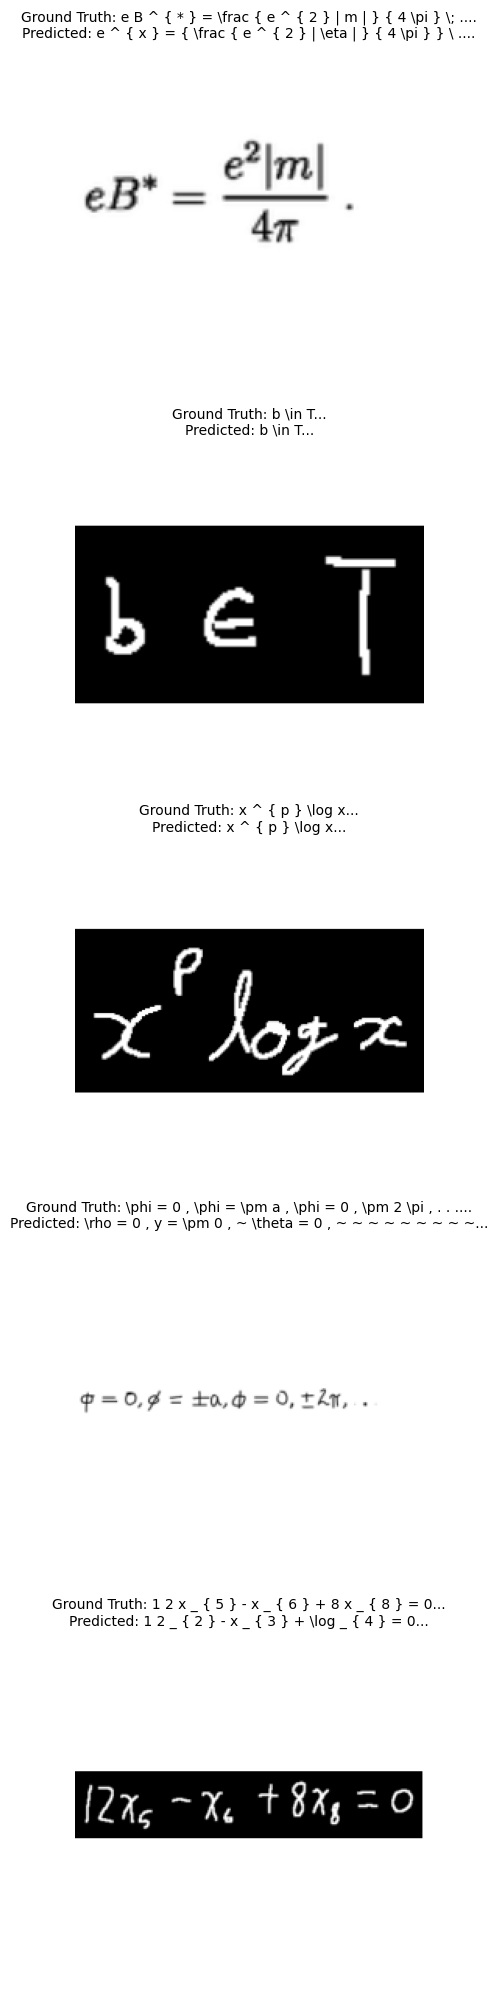

In [36]:
test_inference()